In [2]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['OMP_NUM_THREADS'] = '4'

# os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']= 'platform'
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm
from functools import partial
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import blackjax
from flax.training import train_state
import optax
import jaxopt

import sklearn
import sklearn.datasets

import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import set_matplotlib_formats

set_matplotlib_formats("pdf", "png")
plt.rcParams["savefig.dpi"] = 75
plt.rcParams["figure.autolayout"] = True
plt.rcParams["figure.figsize"] = 6, 4
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.size"] = 16
plt.rcParams["lines.linewidth"] = 2.0
plt.rcParams["lines.markersize"] = 8
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["legend.facecolor"] = "white"
# plt.rcParams['grid.color'] = "grey"
plt.rcParams["text.usetex"] = True
# plt.rcParams['font.family'] = "normal"
# plt.rcParams['font.family'] = "sans-serif"
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams[
    "text.latex.preamble"
] = "\\usepackage{subdepth} \\usepackage{amsfonts} \\usepackage{type1cm}"


/tmp/ipykernel_3584664/2096830287.py:25: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("pdf", "png")


In [4]:
import torch
import sklearn

seed = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### LOAD DATA
def _one_hot(x, k):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k))

_x_train, _y_train = sklearn.datasets.make_moons(
    n_samples=200, shuffle=True, noise=0.2, random_state=seed
)

h = 0.25
test_lim = 3
x_min, x_max = -5, 5
y_min, y_max = -5, 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
_x_test = np.vstack((xx.reshape(-1), yy.reshape(-1))).T

h = 0.25
test_lim = 7
x_wide_min, x_wide_max = (
    _x_train[:, 0].min() - test_lim,
    _x_train[:, 0].max() + test_lim,
)
y_wide_min, y_wide_max = (
    _x_train[:, 1].min() - test_lim,
    _x_train[:, 1].max() + test_lim,
)
xx_wide, yy_wide = np.meshgrid(
    np.arange(x_wide_min, x_wide_max, h), np.arange(y_wide_min, y_wide_max, h)
)
_x_test_wide = np.vstack((xx_wide.reshape(-1), yy_wide.reshape(-1))).T

_y_test = np.ones(_x_test.shape[0])
_y_test_wide = np.ones(_x_test_wide.shape[0])


x_train = _x_train
y_train = _y_train.reshape(-1, 1)

x_test = _x_test
y_test = _y_test.reshape(-1, 1)

x_test_wide = _x_test_wide
y_test_wide = _y_test_wide.reshape(-1, 1)

In [5]:
from flax import linen as nn
from typing import Callable

def count_params(model, x):
    params = model.init(jax.random.PRNGKey(0), x)
    n = sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])
    print(f'Number of parameters: {n/1e3} k')
    
def param_size(params):
    return sum([np.prod(p.shape) for p in jax.tree_util.tree_leaves(params)])

class MLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    act: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        layers = [nn.Dense(self.H)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, nn.Dense(self.H)]
        layers += [self.act, nn.Dense(self.out_size)]
        return nn.Sequential(layers)(x)

def reparam_initializer(initializer, f):
    def init(key, shape, dtype=jnp.float32):
        # sample original parameters and then invert the reparametrization
        return f(initializer(key, shape, dtype))
    return init

class ReparamDense(nn.Module):
    # same as nn.Dense but with reparam weights
    # reparam: Callable = lambda x: x # w = reparam(x)
    # reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    # bias_init: Callable = reparam_initializer(nn.initializers.normal(stddev=1e-6))
    # kernel_init: Callable = reparam_initializer(nn.initializers.lecun_normal())

    def __init__(self, features, reparam, reparam_inv, init_scale=None):
        super().__init__()
        self.features = features
        self.reparam = reparam
        self.reparam_inv = reparam_inv
        # zero init for bias
        if init_scale is None:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=1e-4), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.lecun_normal(), f=reparam_inv)
        else:
            self.bias_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)
            self.kernel_init = reparam_initializer(nn.initializers.normal(stddev=init_scale), f=reparam_inv)

    @nn.compact
    def __call__(self, inputs):
        reparam_kernel = self.param('reparam_kernel', self.kernel_init, (inputs.shape[-1], self.features))
        reparam_bias = self.param('reparam_bias', self.bias_init, (1, self.features)) # not using bias_init to avoid dividing by zero
        # invert weights
        kernel = jax.tree_util.tree_map(self.reparam, reparam_kernel)
        bias = jax.tree_util.tree_map(self.reparam, reparam_bias)
        # clamp to avoid numerical issues
        kernel = jnp.clip(kernel, a_min=-1e6, a_max=1e6)
        bias = jnp.clip(bias, a_min=-1e6, a_max=1e6)
        return jnp.dot(inputs, kernel) + bias

class ReparamMLP(nn.Module):
    out_size: int
    H: int = 64
    hidden_layers: int = 1
    reparam: Callable = lambda x: x # w = reparam(x)
    reparam_inv: Callable = lambda x: x # x = reparam_inv(w)
    act: Callable = nn.tanh
    init_scale: float = None

    @nn.compact
    def __call__(self, x):
        layers = [ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        for _ in range(self.hidden_layers - 1):
            layers += [self.act, ReparamDense(features=self.H, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        layers += [self.act, ReparamDense(features=self.out_size, reparam=self.reparam, reparam_inv=self.reparam_inv, init_scale=self.init_scale)]
        out = nn.Sequential(layers)(x)
        return out

In [6]:
def tree_norm(tree):
    return jnp.sqrt(sum([jnp.sum(x**2) for x in jax.tree_leaves(tree)]))

def random_split_like_tree(rng_key, target=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_structure(target)
    keys = jax.random.split(rng_key, treedef.num_leaves)
    return jax.tree_unflatten(treedef, keys)

@jax.jit
def tree_random_normal_like(rng_key, target):
    keys_tree = random_split_like_tree(rng_key, target)
    return jax.tree_map(
        lambda l, k: jax.random.normal(k, l.shape, l.dtype),
        target,
        keys_tree,
    )

def jacobian_sigular_values(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x) # (b, o, p)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('bo...->...bo', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    P = param_size(p)
    J = J.reshape(P, -1).T # (B*O, P)
    # sigular values of J
    _, S, _ = jnp.linalg.svd(J, full_matrices=False)
    return S

def get_K_matrix(model, p, x):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    N = x.shape[0]
    K = J.T @ J / N # (P, P)
    return K


@partial(jax.jit, static_argnums=(0,3,4))
def log_det_K_svd(model, p, x, jitter=1e-6, return_eig=False):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(s ** 2 + jitter))
    P = param_size(p)
    logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

@partial(jax.jit, static_argnums=(0,3,4))
def log_det_K_svd_first_order(model, p, x, jitter=1e-6, return_eig=False):
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = jnp.sum(jnp.log(jitter) + (s ** 2) / jitter)
    P = param_size(p)
    logdet_svd = logdet_svd - P * jnp.log(jitter)
    if return_eig:
        return logdet_svd, s ** 2
    return logdet_svd

def log_det_K(model, p, x, jitter=1e-6, scale=1.0):
    K = get_K_matrix(model, p, x)
    # add jitter
    K = K + jitter * jnp.eye(K.shape[0])
    s, log_det = jnp.linalg.slogdet(K)
    return log_det
    s = jacobian_sigular_values(model, p, x) / (x.shape[0] ** 0.5)
    logdet_svd = 2 * jnp.sum(jnp.log(s))
    return logdet_svd


def log_det_diagonal_approx(model, p, x, jitter=1e-6):
    jac_rev = jax.jacrev(lambda p, x: model.apply(p, x))
    jac_vmap = jax.vmap(jac_rev, in_axes=(None, 0))
    # j = jac_rev(p, x)
    j = jac_vmap(p, x)
    # move the batch axis to last
    j = jax.tree_util.tree_map(lambda x: jnp.einsum('b...->...b', x), j)
    # flatten j
    J, _ = jax.flatten_util.ravel_pytree(j)
    J = J.reshape(-1, x.shape[0]).T # (N, P)
    avg_j_sq = jnp.mean(J ** 2, axis=0) # (P,)
    logdet_diag = jnp.sum(jnp.log(avg_j_sq + jitter))
    return logdet_diag

def function_instability(model, p, x, dp):
    # p_perturbed = p + dp, both pytrees
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the norm of the difference
    avg_dff_sq = jnp.mean(diff ** 2)
    return avg_dff_sq

@partial(jax.jit, static_argnums=(0,4))
def trace_estimator(model, p, x, dp, sigma=0.1):
    # dp: N(0, I)
    # p_perturbed = p + dp, both pytrees
    # scale dp by sigma
    dp = jax.tree_util.tree_map(lambda x: x * sigma, dp)
    p_perturbed = jax.tree_util.tree_map(lambda x, y: x + y, p, dp)
    # compute the difference between the outputs
    y = model.apply(p, x)
    y_perturbed = model.apply(p_perturbed, x)
    diff = y - y_perturbed
    # compute the avg sq norm of the difference
    avg_dff_sq_norm = jnp.mean((diff ** 2).sum(axis=-1))
    return avg_dff_sq_norm / (sigma ** 2)

def log_det_trace_estimator(model, p, x, jitter, sigma, n_samples=10, normalize=False):
    # sample n_samples dp from N(0, I) and compute the trace estimator
    traces = []
    P = param_size(p)
    rng_key = jax.random.PRNGKey(0)
    for _ in range(n_samples):
        rng_key, rng_key_sample = jax.random.split(rng_key)
        dp = tree_random_normal_like(rng_key_sample, p)
        if normalize:
            scale = (P ** 0.5) / tree_norm(dp)
        else:
            scale = 1.0
        # scale dp to have squared norm P * sigma^2
        dp = jax.tree_util.tree_map(lambda x: x * scale, dp)
        trace = trace_estimator(model, p, x, dp, sigma=sigma)
        traces.append(trace)
    trace = jnp.array(traces).mean()
    return trace / jitter

# def log_det_trace_estimator(model, p, x, jitter, sigma, n_samples=10):
#     # sample n_samples dp from N(0, I) and compute the trace estimator
#     dp_list = []
#     for i in range(n_samples):
#         rng_key = jax.random.PRNGKey(i)
#         dp_list.append(tree_random_normal_like(rng_key, p))
#     dps = jax.tree_map(lambda *x: jnp.stack(x, axis=0), *dp_list)
#     # vamp the trace estimator
#     traces = jax.vmap(trace_estimator, in_axes=(None, None, None, 0, None))(model, p, x, dps, sigma)
#     trace = traces.mean()
#     return trace / jitter

In [7]:
def optimize(lr, prior_scale, n_step, rng_key, loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method='exact', temp=1.0):
    rng_key, init_params_key = jax.random.split(rng_key)
    init_params = jax.jit(model.init)(init_params_key, jnp.ones((1, x_train.shape[1])))
    def get_train_state(optimizer, lr, init_params, warmup_steps=100):
        lr_sched = optax.linear_schedule(0, lr, warmup_steps, transition_begin=0)
        if optimizer == 'adam':
            tx = optax.chain(
                    optax.adam(learning_rate=lr_sched),
                )
            
        elif optimizer == 'sgd':
            tx = optax.sgd(learning_rate=lr_sched, momentum=0.9)
        else:
            raise NotImplementedError
        return train_state.TrainState.create(apply_fn=model.apply, params=init_params, tx=tx)
    
    ts = get_train_state(optimizer, lr, init_params)
    
    def augmented_loss_fn(p, x_eval, dp):
        # loss = likelihood / N = 1 / (2 * sigma^2) * ||y - f(x)||^2 / N
        # it contains a factor 1 / N, where N = x_train.shape[0]
        # all other terms should be divided by N as well
        avg_nll = loss_fn(p) 
        N = x_train.shape[0]
        # number of params
        P = jax.tree_util.tree_leaves(p)[0].shape[0]
        if fsmap:
            if method == 'diag':
                logdet = 1 / 2 * log_det_diagonal_approx(model, p, x_eval, jitter) / N
            elif method == 'exact':
                # svd is much more stable
                logdet = 1 / 2 * log_det_K_svd(model, p, x_eval, jitter) / N
            elif method == 'trace':
                logdet = 1 / 2 * ((1/jitter) * trace_estimator(model, p, x_eval, dp)) / N
            else:
                raise NotImplementedError
        else:
            logdet = 0
        params_flat, unravel = jax.flatten_util.ravel_pytree(p)
        log_p_w = 1 / (2 * (prior_scale ** 2)) * jnp.sum(params_flat ** 2) / N
        logdet =  temp * logdet + (1 - temp) * jax.lax.stop_gradient(logdet)
        return avg_nll + log_p_w + logdet, (avg_nll, logdet)

    grad_fn = jax.jit(jax.value_and_grad(lambda p, x_eval, dp: augmented_loss_fn(p, x_eval, dp), has_aux=True))
    losses = []
    logdets = []
    avg_nlls = []
    def sample_dp(p, rng_key):
        # gaussian tree
        dp = tree_random_normal_like(rng_key, p)
        # # norm of dp flattened
        # dp_flat, _ = jax.flatten_util.ravel_pytree(dp)
        # dp_norm = jnp.sqrt(jnp.sum(dp_flat ** 2))
        # # normalize dp
        # dp = jax.tree_util.tree_map(lambda x: x / dp_norm, dp)
        return dp
    @jax.jit
    def train_step(ts, rng_key):
        rng_key, x_eval_key = jax.random.split(rng_key)
        rng_key, dp_key = jax.random.split(rng_key)
        x_eval = x_eval_generator(x_eval_key)
        dp = sample_dp(ts.params, dp_key)
        (loss, aux), grads = grad_fn(ts.params, x_eval, dp)
        ts = ts.apply_gradients(grads=grads)
        return ts, loss, aux, rng_key
    for _ in tqdm(range(int(n_step))):
        ts, loss, aux, rng_key = train_step(ts, rng_key)
        avg_nll, logdet = aux
        losses.append(loss.item())
        logdets.append(logdet.item())
        avg_nlls.append(avg_nll.item())
    losses = np.array(losses)
    logdets = np.array(logdets)
    avg_nlls = np.array(avg_nlls)
    return ts.params, losses, avg_nlls, logdets

In [8]:
def run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=False, method='exact', jitter=1e-6, temp=1):
    # model
    model = arch(out_size=2)
    x_eval_sample = x_eval_generator(jax.random.PRNGKey(0))
    # count parameters
    init_params = model.init(jax.random.PRNGKey(0), jnp.ones((1, x_train.shape[1])))
    leaves, _ = jax.tree_util.tree_flatten(init_params)
    n_params = sum([np.prod(p.shape) for p in leaves])
    print(f"Number of parameters: {n_params}")

    # softmax multi-task cross entropy loss (not binary)
    y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)
    train_loss_fn = lambda p: jnp.mean(jnp.sum(-jax.nn.log_softmax(model.apply(p, x_train), axis=1) * y_train_one_hot, axis=1))
    
    rng_key = jax.random.PRNGKey(seed)
    params, losses, avg_nlls, logdets = optimize(lr, prior_scale, n_step, rng_key, train_loss_fn, model, x_train, y_train, x_eval_generator, optimizer, fsmap, jitter, method, temp)
    torch.save(params, f'{output_dir}/params_{seed}.pt')
    print('Saved ps parameters at ', f'{output_dir}/params_{seed}.pt')
    # plot and save losses
    plt.figure()
    
    def make_subplots(arrays, labels):
        n_plots = len(arrays)
        fig, axs = plt.subplots(n_plots, 1, figsize=(10, 10))
        for i, (a, label) in enumerate(zip(arrays, labels)):
            q1, q2 = np.quantile(a, [0., 0.95])
            axs[i].plot(a)
            axs[i].set_ylim(q1, q2)
            axs[i].set_xlabel('Step')
            axs[i].set_ylabel(label)
            axs[i].legend()
        plt.show()
    
    make_subplots([losses, avg_nlls, logdets], ['Loss', 'Avg NLL', 'Logdet'])
    
    def log_posterior(model, params, x, jitter):
        log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
        log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
        log_det = log_det_K_svd(model, params, x, jitter)
        print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
        return log_likelihood + log_param_prior - 1 / 2 * log_det
    
    # compute function space posterior 
    log_posterior_learned = log_posterior(model, params, x_test, jitter)
    if gt_params is not None:
        log_posterior_gt = log_posterior(model, gt_params, x_test, jitter)
    else:
        log_posterior_gt = None

    prediction = jax.nn.softmax(model.apply(params, x_test))[..., 1].reshape(xx.shape)

    plt.figure(figsize=(10, 7))
    cbar = plt.contourf(xx, yy, prediction, levels=20, cmap=cm.coolwarm)
    cb = plt.colorbar(cbar,)
    cb.ax.set_ylabel(
        "$\mathbb{E}[\mathbf{y} | \mathcal{D}; \mathbf{x}]$",
        rotation=270,
        labelpad=40,
        size=30,
    )
    # cb.ax.set_ylabel('$E[y | \mathcal{D}; x]$', labelpad=-90)
    cb.ax.tick_params(labelsize=30)
    plt.scatter(
        x_train[y_train[:, 0] == 0][..., 0],
        x_train[y_train[:, 0] == 0][..., 1],
        color="cornflowerblue",
        edgecolors="black",
    )
    plt.scatter(
        x_train[y_train[:, 0] == 1][..., 0],
        x_train[y_train[:, 0] == 1][..., 1],
        color="tomato",
        edgecolors="black",
    )
    plt.tick_params(labelsize=30)
    plt.savefig(f'{output_dir}/{seed}.pdf')
    # show noise_scale, prior_scale on plot
    # plt.text(0.05, 0.9, rf'$\alpha = {prior_scale}$, $\sigma = {noise_scale}$, $\tau = {temp}$', fontsize=20, verticalalignment='top')
    # plt.title(rf'$\alpha = {prior_scale}$, $\tau = {temp}$, $\log p(f|D) = {log_posterior_learned:.0f}$')
    # plt.legend()

In [9]:
activations = {
    'tanh': nn.tanh,
    'elu': nn.elu,
    'cos': jnp.cos,
    'sin': jnp.sin,
    'softplus': nn.softplus,
}


In [ ]:
# PSMAP
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [16]
depths = [2]
acts = ['softplus']


optimizer = 'adam'
lr = 1e-3
n_step = int(2e3)
prior_scales = [1]
noise_scale = 0
n_eval = 400
x_lims = [-5, 5]

def x_eval_generator(rng_key):
    X_eval = x_test
    return X_eval

skip_if_done = True
fsmap = False
temps = [1]
method = 'exact'
jitter = 1e-32

pmap_results = []
for width in widths:
    for depth in depths:
        for act in acts:
            for prior_scale in prior_scales:
                for temp in temps:
                    output_dir = f'psmap'
                    # mkdir if needed
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    for seed in range(1):
                        arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                        result_path = f'{output_dir}/result_{seed}.pt'
                        if os.path.exists(result_path) and skip_if_done:
                            pmap_results.append(torch.load(result_path))
                            print('Loaded result from ', result_path)
                        else:
                            gt_params = None
                            pmap_results.append(run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter))

Number of parameters: 354


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_3584664/3192496830.py:6: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_3584664/3192496830.py:8: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
100%|██████████| 2000/2000 [01:45<00:00, 18.93it/s]


Saved ps parameters at  pathology/params_0.pt


<Figure size 600x400 with 0 Axes>

/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


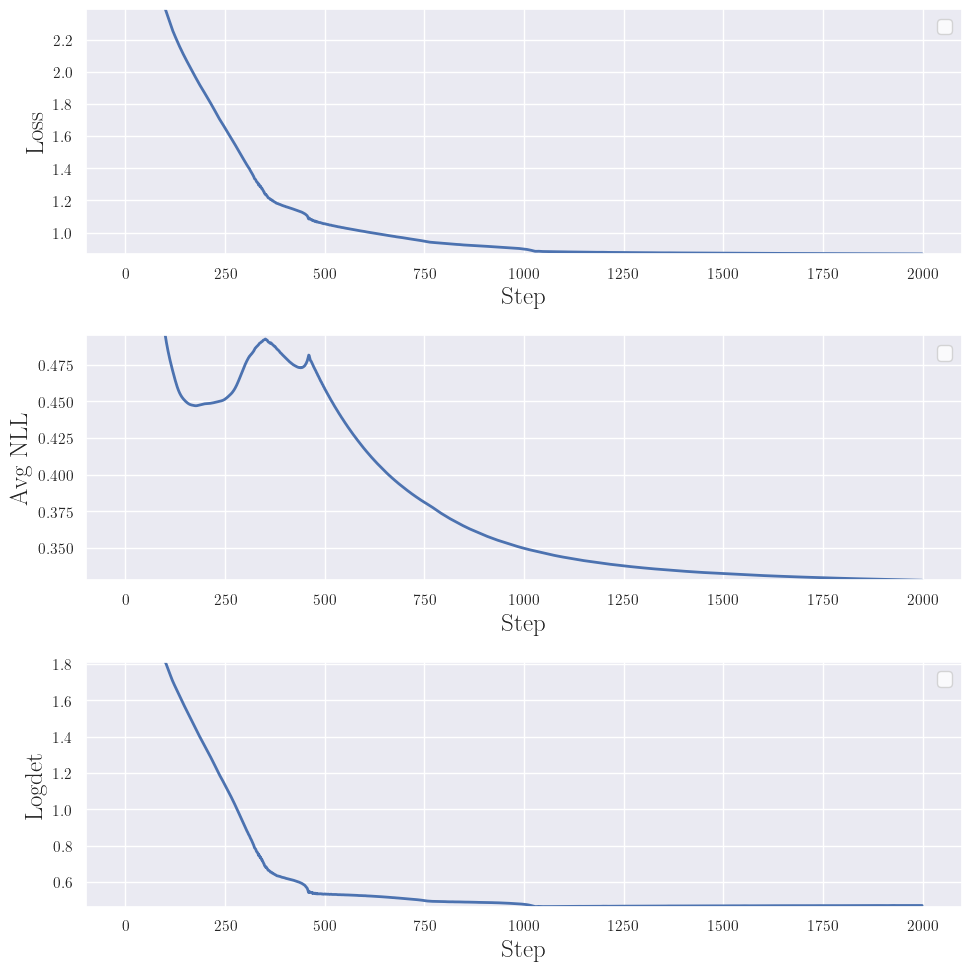

log_likelihood: -65.5801010131836, log_param_prior: -13.545063018798828, log_det: 188.5576171875


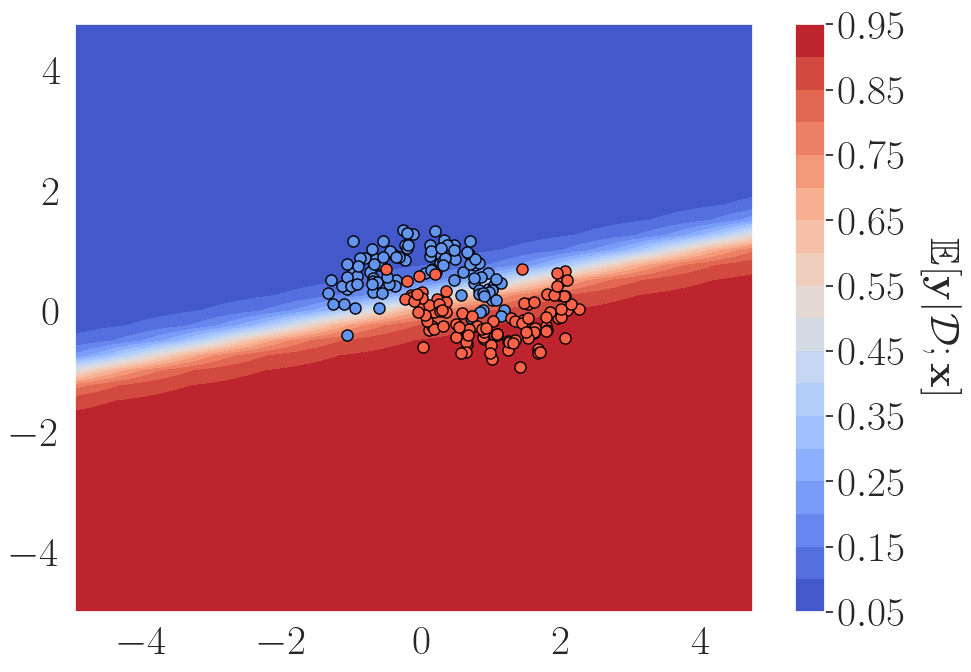

Number of parameters: 354


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_3584664/3192496830.py:6: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_3584664/3192496830.py:8: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
100%|██████████| 2000/2000 [01:45<00:00, 18.93it/s]


Saved ps parameters at  pathology/params_0.pt


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

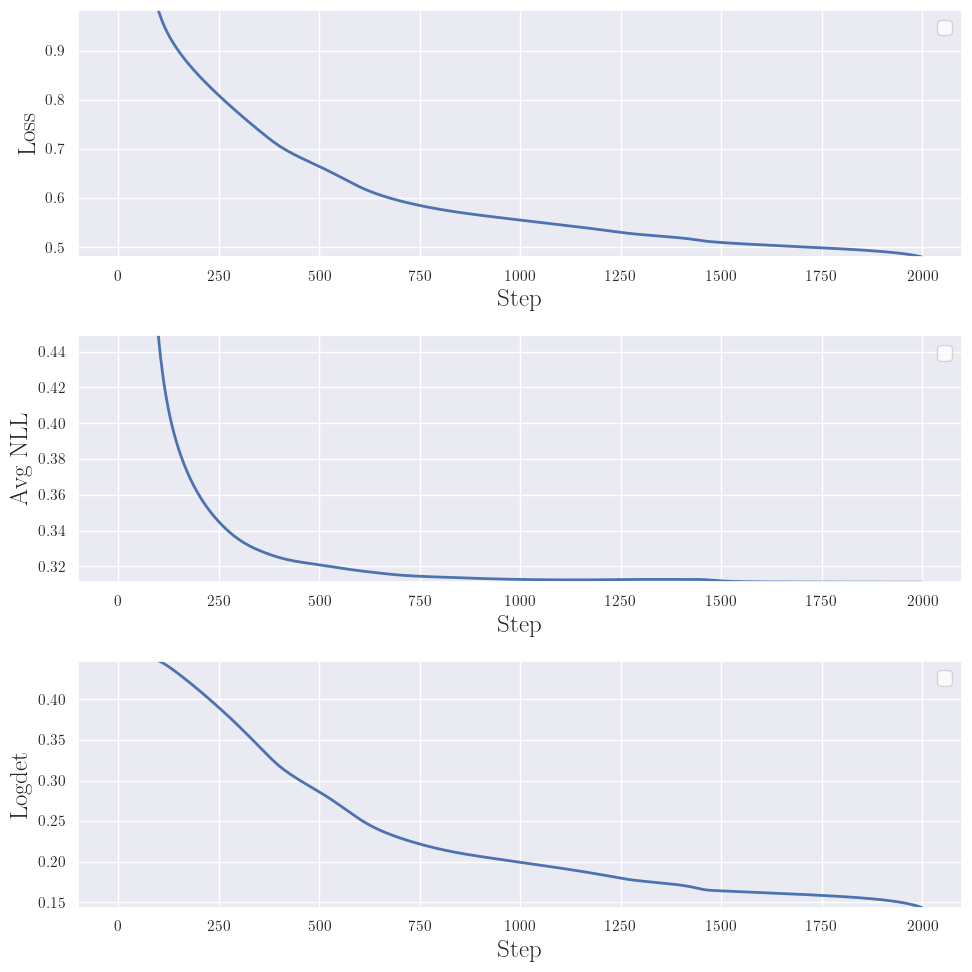

log_likelihood: -62.211997985839844, log_param_prior: -5.1951141357421875, log_det: 57.310791015625


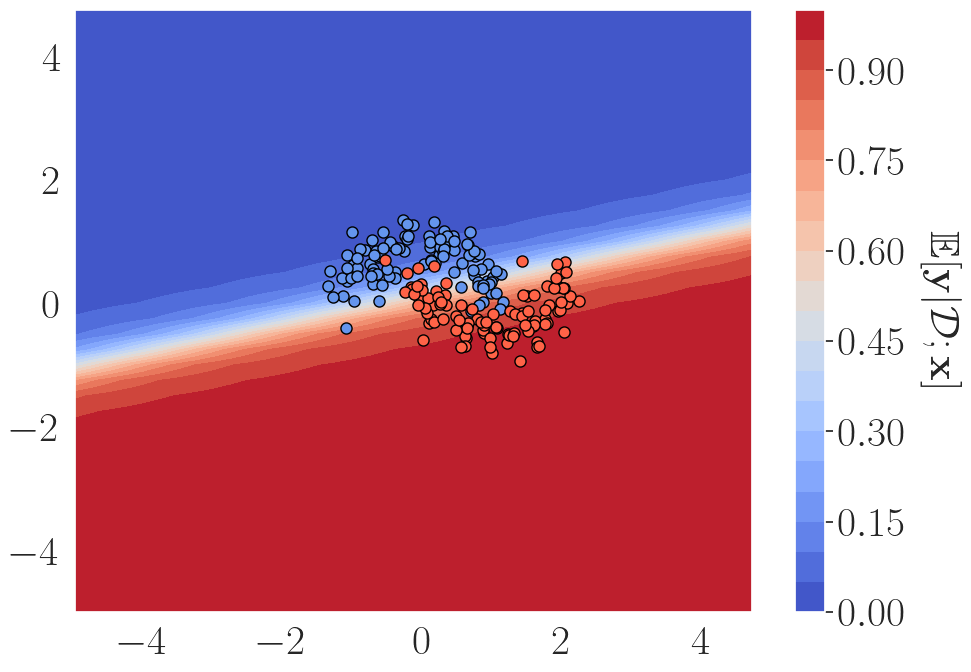

Number of parameters: 354


100%|██████████| 2000/2000 [01:43<00:00, 19.31it/s]


Saved ps parameters at  pathology/params_0.pt


<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


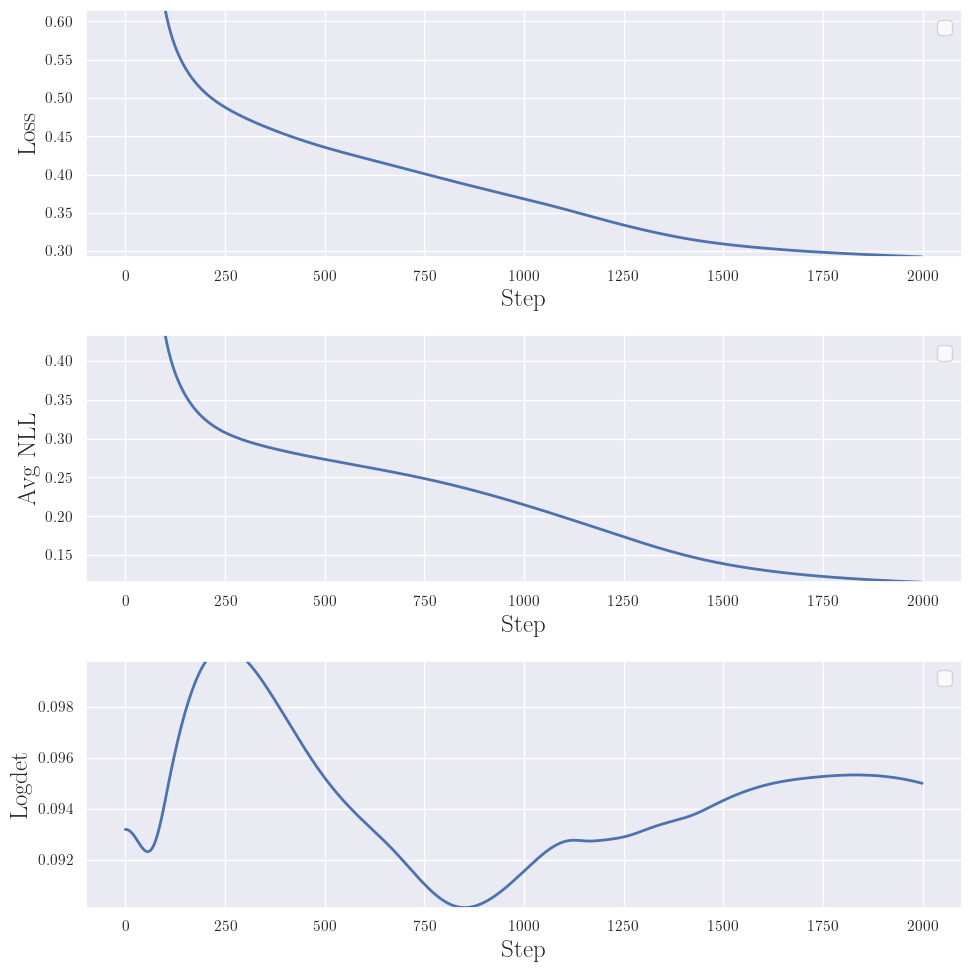

log_likelihood: -22.989015579223633, log_param_prior: -16.49059295654297, log_det: 37.9959716796875


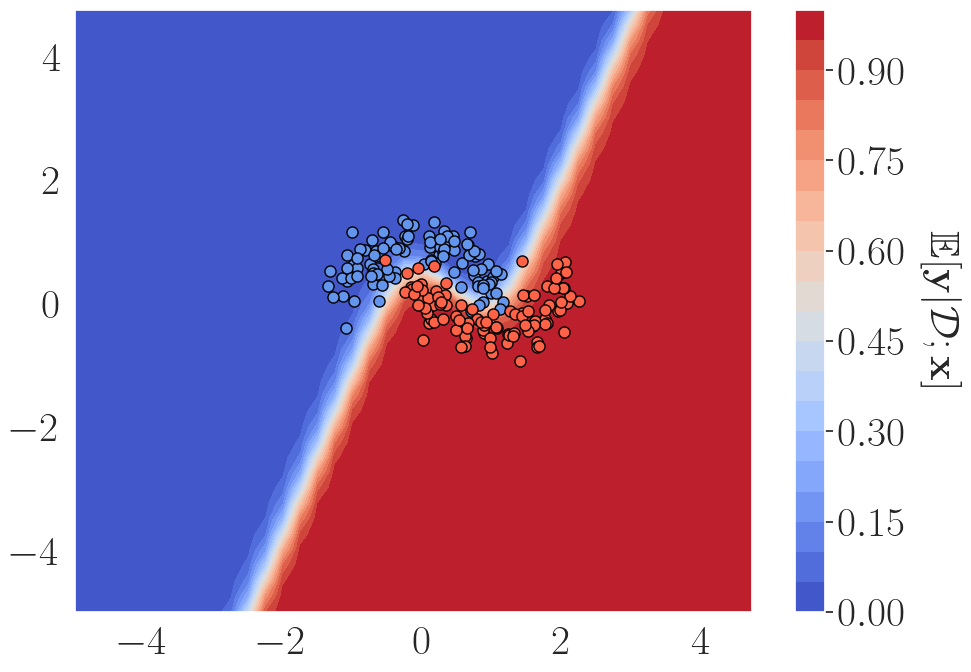

Number of parameters: 354


  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_3584664/3192496830.py:6: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_3584664/3192496830.py:8: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
 93%|█████████▎| 1856/2000 [01:39<00:06, 22.35it/s]

In [10]:
reparam = lambda x: x
reparam_inv = lambda w: w

widths = [16]
depths = [2]
acts = ['tanh']


optimizer = 'adam'
lr = 1e-3
n_step = int(2e3)
prior_scales = [1]
noise_scale = 0
# n_eval = 400
# x_lims = [-5, 5]

def x_eval_generator(rng_key):
    X_eval = x_test
    return X_eval

skip_if_done = True
fsmap = True
temps = [1]
method = 'exact'
# jitter = 1e-32

pmap_results = []
for jitter in [1e-6, 1e-3, 1e-1, 1, 10]:
    for width in widths:
        for depth in depths:
            for act in acts:
                for prior_scale in prior_scales:
                    for temp in temps:
                        output_dir = f'pathology'
                        # mkdir if needed
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)
                        for seed in range(1):
                            arch = partial(ReparamMLP, reparam=reparam, reparam_inv=reparam_inv, H=width, hidden_layers=depth, act=activations[act])
                            result_path = f'{output_dir}/result_{seed}.pt'
                            if os.path.exists(result_path) and skip_if_done:
                                pmap_results.append(torch.load(result_path))
                                print('Loaded result from ', result_path)
                            else:
                                gt_params = None
                                pmap_results.append(run_two_moons(arch, noise_scale, prior_scale, x_train, y_train, x_test, y_test, gt_params, x_eval_generator, n_step, lr, optimizer, output_dir, seed, fsmap=fsmap, method=method, temp=temp, jitter=jitter))
                                plt.show()
                                plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_pred.png')

In [89]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

def subtract_min(x):
    return x
    # return x - np.min(x)

def normalize(v):
    v_norm2 = jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(v)]))
    v = jax.tree_util.tree_map(lambda x: x / jnp.sqrt(v_norm2), v)    
    return v

def log_posterior(model, params, x_train, y_train, x_context, jitter, log_det_fn):
    y_train_one_hot = jax.nn.one_hot(y_train.reshape(-1), 2)
    log_likelihood = jnp.sum(jnp.sum(jax.nn.log_softmax(model.apply(params, x_train), axis=1) * y_train_one_hot, axis=1))
    log_param_prior = -0.5 * jnp.sum(jnp.array([jnp.sum(p ** 2) for p in jax.tree_util.tree_leaves(params)])) / (prior_scale ** 2)
    log_det = log_det_fn(model, params, x_context, jitter)
    # print(f'log_likelihood: {log_likelihood}, log_param_prior: {log_param_prior}, log_det: {log_det}')
    return log_likelihood, log_param_prior, log_det

def scan_posterior(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_K_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    v3 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_3, x.shape), init_params))
    # plot log posterior on the ray spanned by 
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]

    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a in tqdm(alpha):
        for v in [v1, v2, v3]:
            params = jax.tree_util.tree_map(lambda x: x * a, v)
            log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
            log_likelihoods.append(log_likelihood)
            log_param_priors.append(log_param_prior)
            log_dets.append(log_det)

    log_likelihoods = jnp.array(log_likelihoods).reshape(-1, 3)
    log_param_priors = jnp.array(log_param_priors).reshape(-1, 3)
    log_dets = jnp.array(log_dets).reshape(-1, 3)
    return alpha, log_likelihoods, log_param_priors, log_dets

def plot_scan(alpha, log_likelihoods, log_param_priors, log_dets):
    # plot three quantities, as dots not lines
    plt.figure(dpi=100, figsize=(10, 6))
    for i in range(3):
        plt.plot(alpha, -log_likelihoods[:, i], label=r'NLL', color=f'C{i}', linestyle='--')
        plt.plot(alpha, subtract_min(-log_param_priors[:, i]), label=r'$-\Delta\log p_w$', color=f'C{i}', linestyle=':')
        plt.plot(alpha[alpha<0], 1/2 * subtract_min(log_dets[alpha<0, i]), label=rf'$\Delta1/2\log\det$', color=f'C{i}', linestyle='-')
        plt.plot(alpha[alpha>0], 1/2 * subtract_min(log_dets[alpha>0, i]), color=f'C{i}', linestyle='-')
    # put legend outside
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.xlabel(r'$\alpha$')
    plt.tight_layout()
    # plt.savefig('divergence.pdf')



In [37]:
def scan_posterior_2d(model, x_context, jitter, steps, max_alpha=1, log_det_fn=log_det_K_svd):
    rng_key = jax.random.PRNGKey(0)
    init_params = model.init(rng_key, x_train)
    # split key
    rng_key, rng_key_sample_1, rng_key_sample_2, rng_key_sample_3 = jax.random.split(rng_key, 4)
    # gaussian random param
    v1 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_1, x.shape), init_params))
    v2 = normalize(jax.tree_util.tree_map(lambda x: jax.random.normal(rng_key_sample_2, x.shape), init_params))
    # plot log posterior on the ray spanned by v1 and v2
    alpha = jnp.concatenate([-jnp.logspace(jnp.log10(max_alpha), -4, steps), jnp.logspace(-4, jnp.log10(max_alpha), steps)])
    alpha = alpha[alpha != 0]
    # 2d coordinates
    u, v = jnp.meshgrid(alpha, alpha)
    log_likelihoods, log_param_priors, log_dets = [], [], []
    log_posterior_fn = jax.jit(lambda p: log_posterior(model, p, x_train, y_train, x_context, jitter, log_det_fn))
    for a, b in tqdm(zip(u.flatten(), v.flatten())):
        av1 = jax.tree_util.tree_map(lambda x: x * a, v1)
        bv2 = jax.tree_util.tree_map(lambda x: x * b, v2)
        params = jax.tree_util.tree_map(lambda x, y: x + y, av1, bv2)
        log_likelihood, log_param_prior, log_det = log_posterior_fn(params)
        log_likelihoods.append(log_likelihood)
        log_param_priors.append(log_param_prior)
        log_dets.append(log_det)
    log_likelihoods = jnp.array(log_likelihoods)
    log_param_priors = jnp.array(log_param_priors)
    log_dets = jnp.array(log_dets)
    return u, v, log_likelihoods, log_param_priors, log_dets
    
def plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets):
    # three subplots
    fig, axs = plt.subplots(1, 3, dpi=100, figsize=(30, 10))
    # plot delta log det
    axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20)
    axs[0].set_title(r'$\Delta\log\det$')
    axs[0].set_xlabel(r'$\alpha$')
    axs[0].set_ylabel(r'$\beta$')
    # make image square
    axs[0].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[0].contourf(u, v, subtract_min(log_dets).reshape(u.shape), levels=20), ax=axs[0])
    # plot NLL
    axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20)
    axs[1].set_title(r'NLL')
    axs[1].set_xlabel(r'$\alpha$')
    axs[1].set_ylabel(r'$\beta$')
    axs[1].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[1].contourf(u, v, -log_likelihoods.reshape(u.shape), levels=20), ax=axs[1])
    # plot delta -log p_w
    axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20)
    axs[2].set_title(r'$-\Delta\log p_w$')
    axs[2].set_xlabel(r'$\alpha$')
    axs[2].set_ylabel(r'$\beta$')
    axs[2].set_aspect('equal')
    # colorbar
    cbar = fig.colorbar(axs[2].contourf(u, v, subtract_min(-log_param_priors).reshape(u.shape), levels=20), ax=axs[2])
    plt.tight_layout()

def plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets):
    # same but plot in 3d
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(u, v, subtract_min(log_dets).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$\Delta\log\det$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$\Delta\log\det$')
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(u, v, -log_likelihoods.reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'NLL')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'NLL')
    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(u, v, subtract_min(-log_param_priors).reshape(u.shape), cmap='viridis', edgecolor='none')
    ax.set_title(r'$-\Delta\log p_w$')
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    ax.set_zlabel(r'$-\Delta\log p_w$')
    plt.tight_layout()

Number of parameters: 0.354 k


  0%|          | 0/20 [00:00<?, ?it/s]

J: (3200, 354)
s.shape (354,)


100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


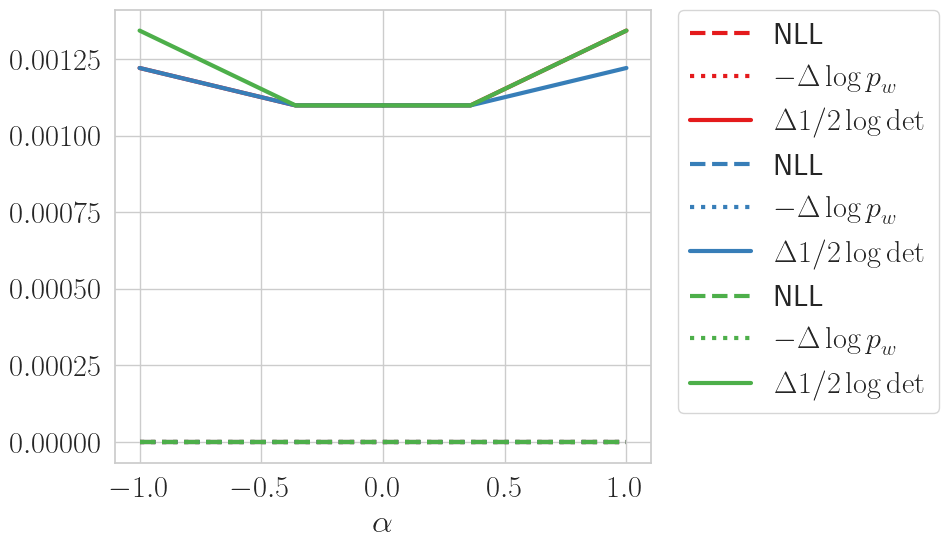

In [92]:
width = 16
depth = 2
act = 'tanh'
prior_scale = 1
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
count_params(model, x_train)
x_context = x_test

for jitter in [1000]:
    alpha, log_likelihoods, log_param_priors, log_dets = scan_posterior(model, x_context, jitter, steps=10, max_alpha=1)
    plot_scan(alpha, 0*log_likelihoods, 0*log_param_priors, log_dets)
    plt.show()
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.png')
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.pdf')

Number of parameters: 0.354 k


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_2824755/1802522724.py:3: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  treedef = jax.tree_structure(target)
/tmp/ipykernel_2824755/1802522724.py:5: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, keys)
100%|██████████| 20/20 [00:10<00:00,  1.97it/s]
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figur

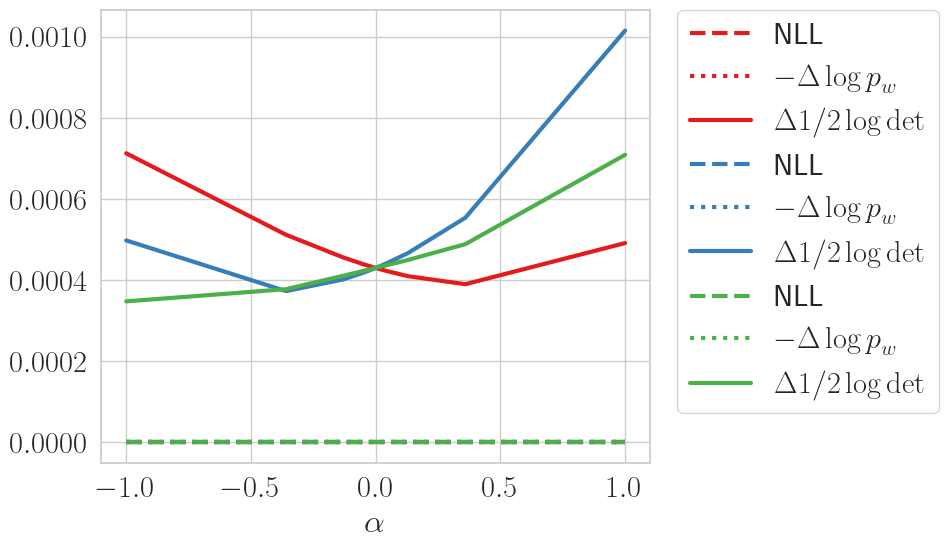

In [93]:
width = 16
depth = 2
act = 'tanh'
prior_scale = 1
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)
count_params(model, x_train)
x_context = x_test

log_det_fn = lambda model, p, x, jitter: log_det_trace_estimator(model, p, x, jitter, sigma=0.01, n_samples=10)
for jitter in [1000]:
    alpha, log_likelihoods, log_param_priors, log_dets = scan_posterior(model, x_context, jitter, steps=10, max_alpha=1, log_det_fn=log_det_fn)
    plot_scan(alpha, 0*log_likelihoods, 0*log_param_priors, log_dets)
    plt.show()
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.png')
    # plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}.pdf')

In [ ]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

for jitter in [1e-1]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface.png')

In [ ]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

log_det_fn = lambda model, p, x, jitter: log_det_trace_estimator(model, p, x, jitter, sigma=0.1, n_samples=10)
for jitter in [1e-1]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100, log_det_fn=log_det_fn)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_tr.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_tr.png')

In [ ]:
width = 16
depth = 4
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

for jitter in [1e-32, 1e-6, 1e-3]:
    u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=100)
    torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}.pt')
    plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour.png')
    plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
    plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface.png')

In [ ]:
width = 16
depth = 2
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

jitter = 1e-32
u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=1000)
torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}_wide.pt')
plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_wide.png')
plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_wide.png')

In [ ]:
width = 16
depth = 4
act = 'elu'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

jitter = 1e-32
u, v, log_likelihoods, log_param_priors, log_dets = scan_posterior_2d(model, x_context, jitter, steps=30, max_alpha=1000)
torch.save((u, v, log_likelihoods, log_param_priors, log_dets), f'pathology/{act}_l{depth}h{width}j{jitter}_wide.pt')
plot_scan_2d(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_contour_wide.png')
plot_scan_2d_surface(u, v, log_likelihoods, log_param_priors, log_dets)
plt.savefig(f'pathology/{act}_l{depth}h{width}j{jitter}_surface_wide.png')

## Comparing objectives ##

In [12]:
width = 16
depth = 2
act = 'tanh'
arch = partial(ReparamMLP, reparam=lambda x: x, reparam_inv=lambda x: x, H=width, hidden_layers=depth, act=activations[act])
model = arch(out_size=2)

rng_key = jax.random.PRNGKey(0)
init_params = model.init(rng_key, x_train)
# log_det_K_svd_fn = jax.jit(lambda params, x_context, jitter: log_det_K_svd(model, params, x_context, jitter, return_eig=True), static_argnums=(3,))
# log_det_trace_estimator_fn = jax.jit(lambda params, x_context, jitter, sigma, n_samples: log_det_trace_estimator(model, params, x_context, jitter, sigma, n_samples), static_argnums=(3,4,5))

In [117]:
points = 50
x_context = x_test
jitter = 1000
# trace estimator
n_samples = 100
sigma = 0.001 # noise scale

logdet_svds = []
logdet_traces = []
max_eigs = []
for _ in tqdm(range(points)):
    rng_key, rng_key_sample = jax.random.split(rng_key)
    params = model.init(rng_key_sample, x_train[0][None, :])
    logdet_svd, eig = log_det_K_svd(model, params, x_context, jitter, return_eig=True)
    logdet_svds.append(logdet_svd)
    max_eigs.append(eig.max().item())
    logdet_traces.append(log_det_trace_estimator(model, params, x_context, jitter, sigma, n_samples).item())

logdet_traces = np.array(logdet_traces)
logdet_svds = np.array(logdet_svds)
    

100%|██████████| 50/50 [00:38<00:00,  1.31it/s]


/home/shikai_q/anaconda3/envs/fspace/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


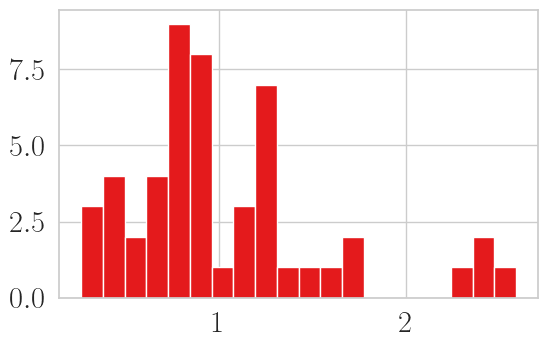

In [118]:
ratio = (logdet_traces / logdet_svds)
_ = plt.hist(ratio, bins=20)

Text(0, 0.5, 'logdet trace')

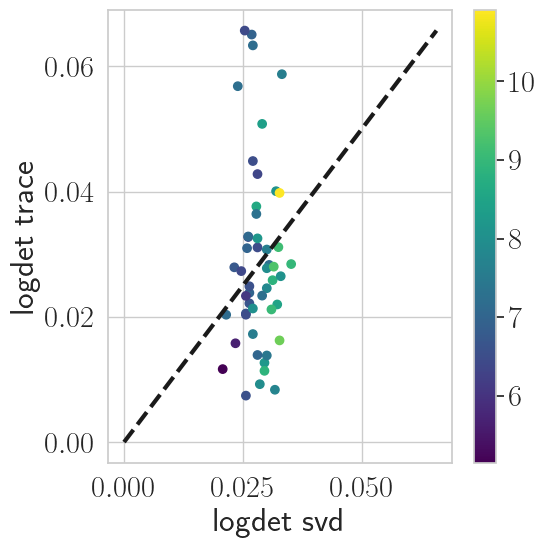

In [119]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style="whitegrid", font_scale=2.0, rc={"lines.linewidth": 3.0})
sns.set_palette("Set1")

# a nice square plot to compare logdet_svds, logdet_traces
# color the points by min_eig and plot a colorbar

plt.figure(figsize=(6,6))
plt.scatter(logdet_svds, logdet_traces, c=max_eigs, cmap='viridis')

plt.colorbar()
# # a diagonal line spanning the range of the data
min_logdet = min(min(logdet_svds), min(logdet_traces))
max_logdet = max(max(logdet_svds), max(logdet_traces))
plt.plot([0, max_logdet], [0, max_logdet], 'k--')

# label the axes
plt.xlabel('logdet svd')
plt.ylabel('logdet trace')

